# Importing libraries

In [1]:
import requests 
from bs4 import BeautifulSoup 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import gmaps
import ipywidgets as widgets
key="YOUR API KEY"
gmaps.configure(api_key=key)

# Importing live dataset

In [2]:
def check(stat):
    if all(len(x) == 0 for x in stat):
        return 0
    return 1
def get_response(URL):
    response = requests.get(URL).content 
    soup = BeautifulSoup(response, 'html.parser')
    all_rows = soup.find_all('tr') 
    return all_rows
def get_data(all_rows,length,omit,data_type):
    extract_contents = lambda row: [x.text.replace('\n', '') for x in row]
    stats = []
    flag=0
    for row in all_rows: 
        stat = extract_contents(row.find_all('td'))
        if stat: 
            if len(stat[:-omit]) ==length and check(stat[1:]): 
                if flag==0:
                    header=stat[:-omit]
                    flag=1
                    continue
                stats.append(stat[:-omit])
    data=pd.DataFrame(stats)
    if data_type=='Travel History':
        header[0]='Serial No.'
    data.columns=header
    return data



In [94]:
URL="https://docs.google.com/spreadsheets/d/e/2PACX-1vSc_2y5N0I67wDU38DjDh35IZSIS30rQf7_NYZhtYYGU1jJYT6_kDx4YpF-qw0LSlGsBYP8pqM_a1Pd/pubhtml"
#contents=get_response(URL)
data=get_data(contents,19,7,'Raw_Data')
data_death_and_recovered=get_data(contents,15,7,'Death and Recovered')
data_travel_history=get_data(contents,11,1,"Travel History")
data_total_tested=get_data(contents,13,1,'StateWise_Tested_Numbers_Data')

#Organising Live dataset and converting to respective data *types*

In [95]:
data=data[:-1]
data=data.replace("EVACUEES","Evacuees")
data['Date Announced'] = pd.to_datetime(data['Date Announced'], format="%d/%m/%Y")
for i in range(len(data)):
    if(len(data.loc[i]['Age Bracket'].split("-"))>1):
        data.at[i,'Age Bracket']=data.loc[i]['Age Bracket'].split("-")[1]
data['Age Bracket']=pd.to_numeric(data['Age Bracket'])

In [124]:
data.replace('', np.nan,inplace=True)

In [96]:
data_total_tested['Num Isolation Beds']=[row['Num Isolation Beds'].replace(",","") for index,row in data_total_tested.iterrows()]
data_total_tested['Total Tested']=pd.to_numeric(data_total_tested['Total Tested'])
data_total_tested = data_total_tested[data_total_tested['Total Tested'].notna()]
data_total_tested['Positive']=pd.to_numeric(data_total_tested['Positive'])
data_total_tested['Negative']=pd.to_numeric(data_total_tested['Negative'])
data_total_tested['Unconfirmed']=pd.to_numeric(data_total_tested['Unconfirmed'])
data_total_tested['Total People In Quarantine']=pd.to_numeric(data_total_tested['Total People In Quarantine'])
data_total_tested['Num Isolation_Beds']=pd.to_numeric(data_total_tested['Num Isolation Beds'])
data_total_tested['Num ICU_Beds']=pd.to_numeric(data_total_tested['Num ICU Beds'])
data_total_tested['Num Ventilators']=pd.to_numeric(data_total_tested['Num Ventilators'])

# Detected cases


1. State
2. Gender
3. Nationality




In [31]:
detected_cases = data.groupby("Detected State").size()
detected_cases.sort_values(ascending=False)

Detected State
Maharashtra                    1364
Tamil Nadu                      834
Delhi                           720
Rajasthan                       489
Telangana                       471
Madhya Pradesh                  411
Uttar Pradesh                   410
Andhra Pradesh                  365
Kerala                          356
Gujarat                         308
Karnataka                       197
Jammu and Kashmir               184
Haryana                         175
Punjab                          130
West Bengal                     116
Bihar                            60
Odisha                           48
Uttarakhand                      35
Assam                            29
Himachal Pradesh                 28
Chhattisgarh                     18
Chandigarh                       18
Ladakh                           15
Jharkhand                        14
Andaman and Nicobar Islands      11
Goa                               7
Puducherry                        5
Manipur      

In [32]:
data.groupby("Gender").size()

Gender
     5143
F     456
M    1225
dtype: int64

In [33]:
detected_nationality = data.groupby("Nationality").size()
detected_nationality.sort_values(ascending=False)

Nationality
                            5643
India                       1122
Italy                         18
Indonesia                     15
Indian                         9
United Kingdom                 7
Thailand                       2
Phillipines                    2
United States of America       1
Tibet                          1
Myanmar                        1
Malaysia                       1
Indai                          1
Canada                         1
dtype: int64

# Plots

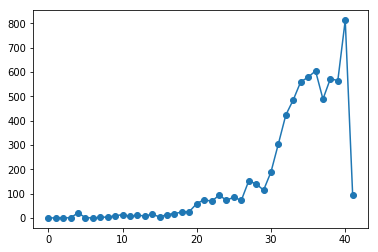

In [34]:
x=np.array(data.groupby("Date Announced").size())
plt.plot(x, marker='o')

## Analysis of data

In [122]:
detected_nationality = data_death_and_recovered.groupby(["Age Bracket","Patient Status"]).size()
detected_nationality[:,"Deceased"]

Age Bracket
      107
1       1
25      1
30      1
36      1
38      1
40      1
41      2
42      2
44      2
45      4
46      2
47      3
48      2
49      2
50      4
51      2
52      8
53      2
54      4
55      7
56      2
57      2
58      2
59      2
60      4
61      2
62      4
63      1
64      3
65     10
66      1
67      8
68      2
69      2
70      3
71      1
72      4
73      1
75      4
77      1
78      2
80      5
85      3
86      1
dtype: int64

Population Pyramid for infections

In [141]:
df_age = data[['Gender', 'Age Bracket']].copy()
df_age.dropna(how='any', subset=['Gender', 'Age Bracket'],inplace=True)

In [142]:
df_age['age'] = df_age.apply(lambda x : pd.to_numeric((x['Age Bracket'])),axis=1)

In [143]:
# Putting data into age groups
bins = [x for x in range(0,100,10)]
df_age['age_group'] = pd.cut(df_age['age'], bins=bins)
print(df_age)

     Gender  Age Bracket   age     age_group
2         M         45.0  45.0  (40.0, 50.0]
3         M         24.0  24.0  (20.0, 30.0]
4         M         69.0  69.0  (60.0, 70.0]
19        F         70.0  70.0  (60.0, 70.0]
22        F         45.0  45.0  (40.0, 50.0]
24        M         16.0  16.0  (10.0, 20.0]
27        M         27.0  27.0  (20.0, 30.0]
28        M         59.0  59.0  (50.0, 60.0]
30        M         65.0  65.0  (60.0, 70.0]
31        M         75.0  75.0  (70.0, 80.0]
32        M         45.0  45.0  (40.0, 50.0]
33        M         24.0  24.0  (20.0, 30.0]
34        M         54.0  54.0  (50.0, 60.0]
35        F         53.0  53.0  (50.0, 60.0]
36        M         65.0  65.0  (60.0, 70.0]
37        F         61.0  61.0  (60.0, 70.0]
38        F         25.0  25.0  (20.0, 30.0]
39        F         63.0  63.0  (60.0, 70.0]
41        M          3.0   3.0   (0.0, 10.0]
45        M         48.0  48.0  (40.0, 50.0]
49        M         40.0  40.0  (30.0, 40.0]
51        

In [144]:
# Convert groupby to dataframe
ndf = pd.DataFrame({'count' : df_age.groupby(['age_group', 'Gender']).size()}).reset_index()
# convert count values of females to negative
ndf.loc[ndf.Gender == 'F', 'count']=-ndf.loc[ndf.Gender == 'F', 'count']
ndf

,age_group,Gender,count
0,"(0, 10]",F,-14
1,"(0, 10]",M,15
2,"(10, 20]",F,-25
3,"(10, 20]",M,54
4,"(20, 30]",F,-60
5,"(20, 30]",M,148
6,"(30, 40]",F,-39
7,"(30, 40]",M,205
8,"(40, 50]",F,-38
9,"(40, 50]",M,126


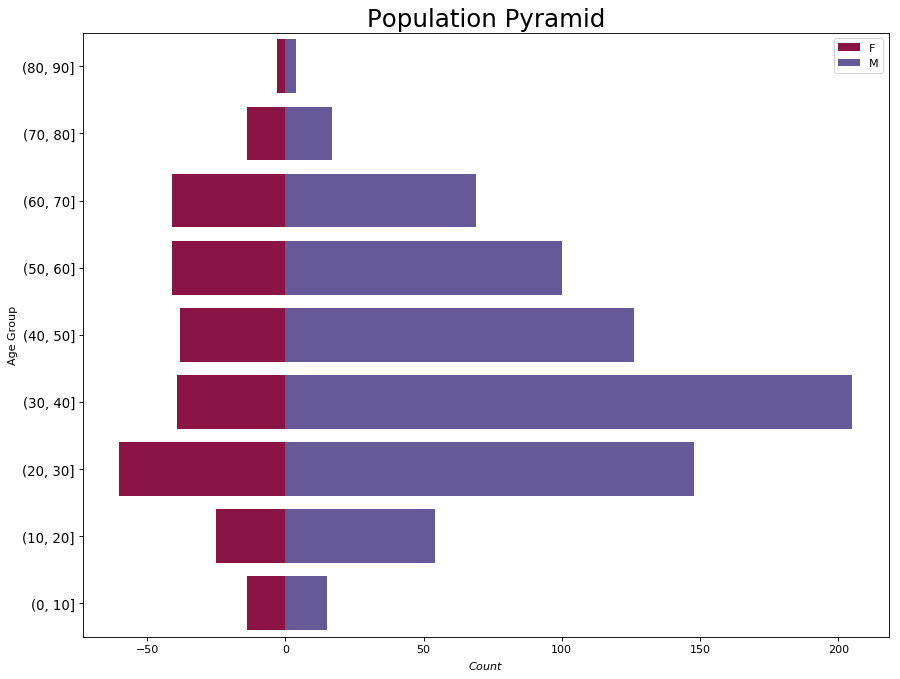

In [145]:
import seaborn as sns

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
group_col = 'Gender'
order_of_bars = ndf['age_group'].unique()[::-1]
colors = [plt.cm.Spectral(i/float(len(ndf[group_col].unique())-1)) for i in range(len(ndf[group_col].unique()))]

#print(colors, ndf[group_col].unique())
for c, group in zip(colors, ndf[group_col].unique()):
    sns.barplot(x='count', y='age_group', data=ndf.loc[ndf[group_col]==group, :], order=order_of_bars, color=c, label=group)

# Decorations    
plt.xlabel("$Count$")
plt.ylabel("Age Group")
plt.yticks(fontsize=12)
plt.title("Population Pyramid", fontsize=22)
plt.legend()
plt.show()

average age of corona infected patients

In [146]:
age=data['Age Bracket']
age=age.dropna()
sum(age)/len(age)



40.54930875576037

In [37]:
gender_status = data.groupby(["Gender","Current Status"]).size()
gender_status['F',"Deceased"]/(gender_status['F',"Deceased"]+gender_status['F',"Recovered"])

0.24242424242424243

In [38]:
gender_status[:,"Deceased"]/(gender_status[:,"Deceased"]+gender_status[:,"Recovered"])

Gender
     0.041667
F    0.242424
M    0.276923
dtype: float64

Percentage of positive cases

In [107]:
percentage=pd.DataFrame(0,columns=['Total Tested','Positive','Negative','Percentage'],index=[keys for keys in data_total_tested.groupby('State').size().keys()])
for index,rows in data_total_tested.iterrows():
        percentage.loc[rows['State']]['Total Tested']=rows['Total Tested']
        percentage.loc[rows['State']]['Positive']=rows['Positive']
        percentage.loc[rows['State']]['Negative']=rows['Negative']
percentage['Percentage']=percentage['Positive']/percentage['Total Tested']
percentage.sort_values(by='Total Tested',ascending=False)

# Save in a list, all the cluster of patient



In [111]:
cluster=[]
for index, rows in data.iterrows(): 
    if(len(rows['Contracted from which Patient (Suspected)'])>0):
        contracted_from=rows['Contracted from which Patient (Suspected)'].split(',')
        contracted_from.append("P"+rows['Patient Number'])
        cluster.append(contracted_from)
    else:
        cluster.append(["P"+rows['Patient Number']])

Removing sublists from the entire list

In [112]:
def removeSublist(lst): 
    curr_res = [] 
    result = [] 
    for ele in sorted(map(set, lst), key = len, reverse = True): 
        if not any(ele <= req for req in curr_res): 
            curr_res.append(ele) 
            result.append(list(ele)) 
          
    return result 
      
# Driver code 
cluster=removeSublist(cluster)

Finding all connected components and creating Graph

In [113]:
import networkx as nx 
G=nx.Graph()
for l in cluster:
    nx.add_path(G, l)
connected_components=list(nx.connected_components(G))

Removing all connected components having no. of nodes less than

In [114]:
threshold_lower=10
threshold_upper=50
remove=nx.Graph()
for c in nx.connected_components(G):
    if(len(c)<threshold_lower or len(c)>threshold_upper):
        remove.add_nodes_from(c)
    else:
        print(c)
        print(len(c))
G.remove_nodes_from(remove)

{'P37', 'P38', ' P37', 'P39', 'P50', 'P35', 'P49', 'P58', ' P36', 'P36', 'P59', 'P555', 'P57', ' P38', 'P56'}
15
{'P1178', 'P1186', 'P1188', 'P1180', 'P1182', 'P1187', 'P1176', 'P301', 'P1177', 'P1079', 'P1174', 'P1175', 'P1078', 'P1077', 'P750', 'P653', 'P1183', 'P1184', 'P1076', 'P1181', 'P751', ' P302', 'P749', 'P502', 'P1179', 'P1185', 'P748'}
27
{'P17', 'P6', 'P14', 'P19', 'P8', 'P9', 'P12', 'P7', 'P20', 'P13', 'P28', 'P16', 'P11', 'P10', 'P21', 'P18', 'P15'}
17
{'P533', 'P359', 'P306', 'P182', 'P639', 'P305', 'P535', 'P309', 'P304', 'P311', 'P388', 'P361', 'P802', 'P358', 'P488', 'P360', 'P801', 'P534', 'P307', 'P308', 'P687', 'P800'}
22
{'P761', 'P676', 'P981', 'P677', 'P979', 'P1048', 'P980', 'P762', 'E1', 'P675', 'P763', 'P933'}
12
{'P769', 'P764', 'P766', 'P770', 'P771', 'P775', 'P767', 'P768', 'P765', 'P772', 'P774', 'P773'}
12
{'P3243', 'P1716', 'P1951', 'P1015', 'P4365', 'P1213', 'P2483', 'P689', 'P6210', 'P1421', 'P6211', 'P4370', 'P1214', 'P1014', 'P2482', 'P1422', 'P195

# Plotting Clusters

C:\Users\user\.conda\envs\tcs\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


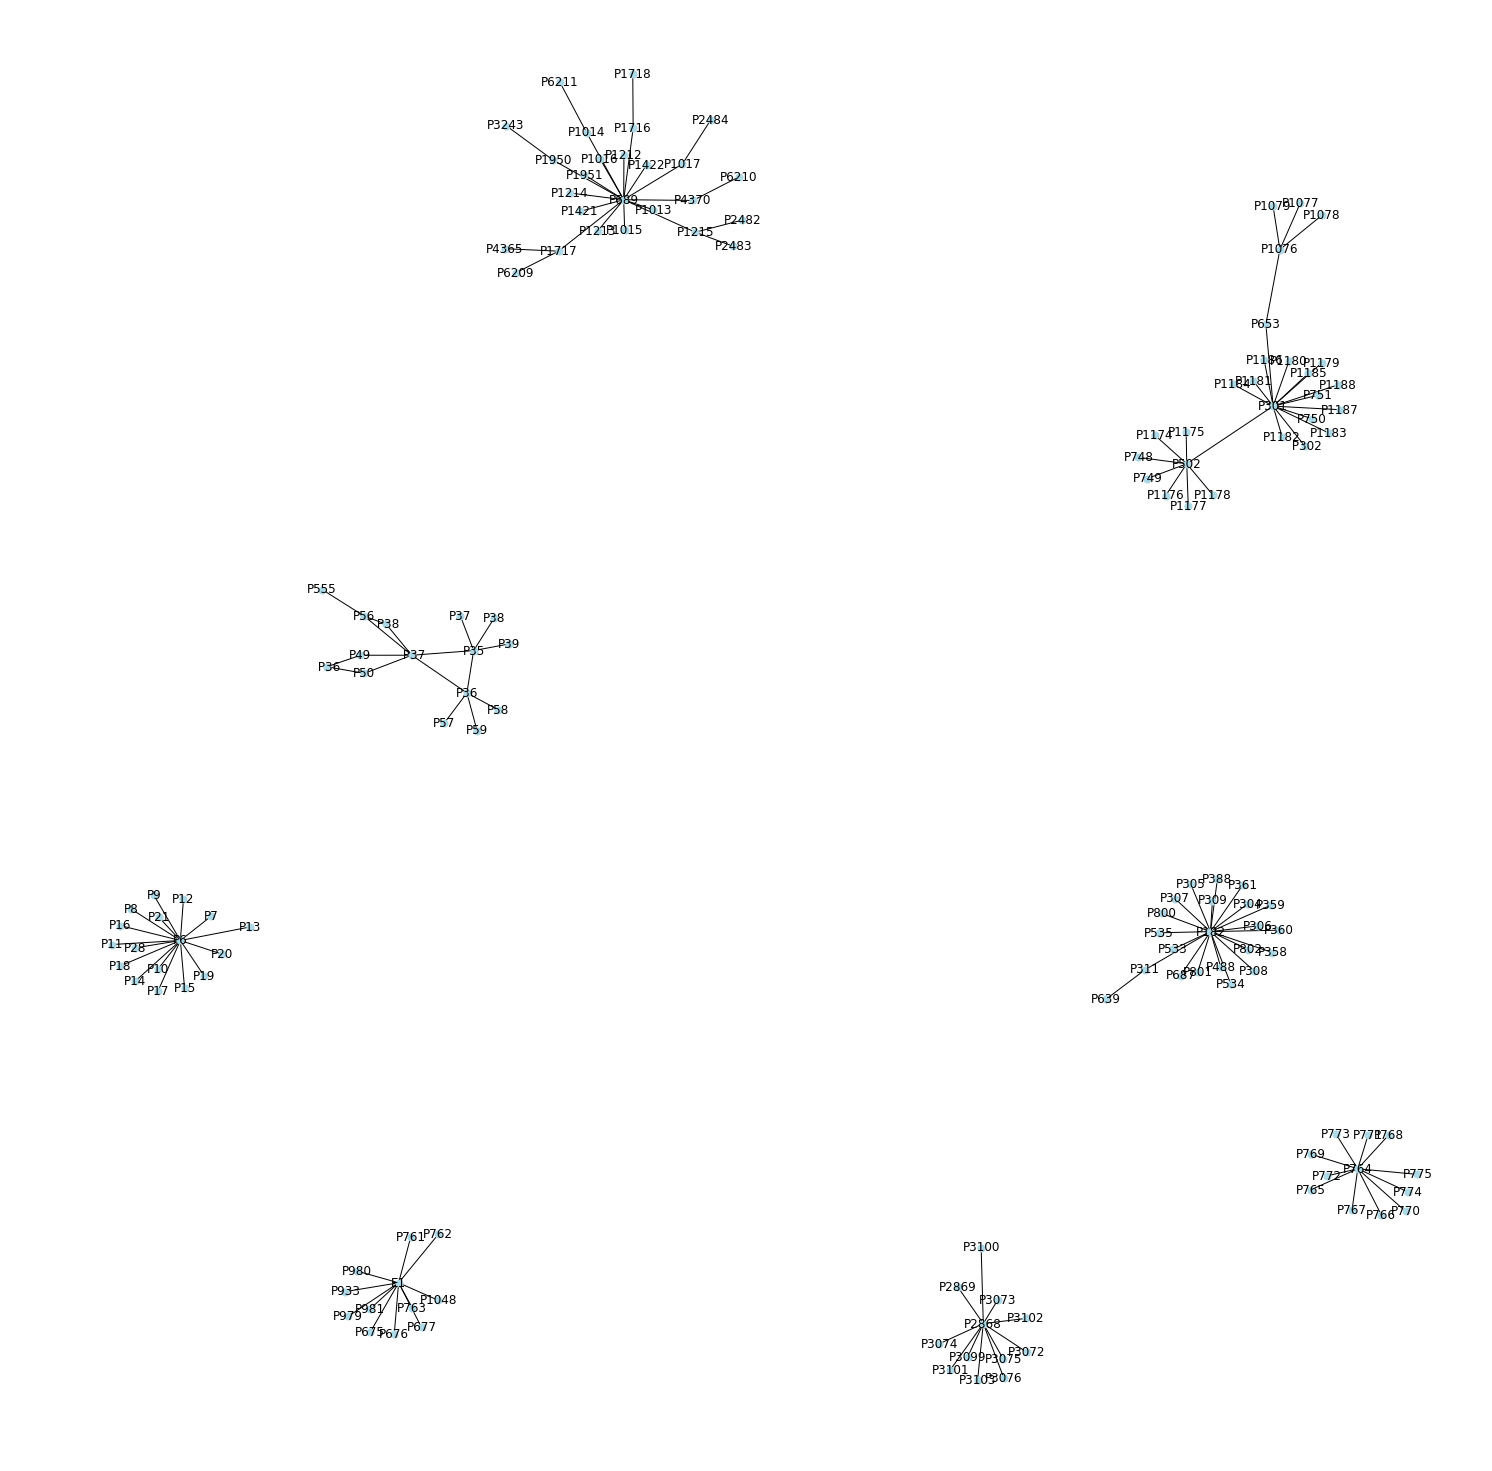

In [115]:
pos = nx.spring_layout(G, scale=1)
plt.figure(3,figsize=(20,20)) 
nx.draw(G, pos, node_color='lightblue', node_size=50, with_labels=True)

# Super Spreaders




In [116]:
super_spreaders=[]
header=['spreading_factor']
header.extend(data.columns.values)
for node in G.nodes:
    if G.degree(node)>2 and node.startswith('P'):
        l=[G.degree(node)]
        l.extend(data[data['Patient Number']==str(node)[1:]].values[0])
        super_spreaders.append(l)
super_spreaders=pd.DataFrame(super_spreaders,columns=header)
super_spreaders.sort_values(by='spreading_factor',ascending=False)


,spreading_factor,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
6,20,182,PJ-P2,2020-03-19,70.0,M,Banga,Shahid Bhagat Singh Nagar,Punjab,PB,Deceased,Travelled from Germany via Italy,,India,Imported,19/03/2020,https://www.indiatoday.in/india/story/coronavi...,https://www.latestly.com/india/news/baldev-sin...,https://punjabupdate.com/media-bulletin-21-03-...,Arrived from Germany via Italy
5,16,6,,2020-03-03,69.0,M,Jaipur,Italians*,Rajasthan,RJ,Recovered,Travelled from Italy,,Italy,Imported,03/03/2020,https://indianexpress.com/article/india/corona...,https://economictimes.indiatimes.com/news/poli...,https://twitter.com/PTI_News/status/1240878975...,Italian tourist
8,16,689,KA-P52,2020-03-26,35.0,M,,Mysuru,Karnataka,KA,Hospitalized,Had been in contact with healthcare profession...,,India,TBD,26/03/2020,https://twitter.com/DHFWKA/status/124310447054...,,,
3,15,301,TN-P5,2020-03-21,69.0,M,Perundurai,Erode,Tamil Nadu,TN,Hospitalized,Travelled from Phuket to New Delhi to Erode ra...,,Thailand,Imported,21/03/2020,https://twitter.com/Vijayabaskarofl/status/124...,,,Details awaited
7,11,764,,2020-03-27,NaN,,,Sangli,Maharashtra,MH,Hospitalized,Related to a previous patient from Sangli - Ta...,,India,Local,27/03/2020,https://twitter.com/ANI/status/124347964054443...,,,
12,11,2868,,2020-04-03,NaN,M,,Morena,Madhya Pradesh,MP,Hospitalized,Travelled from Dubai; hosted feast for 1500 pe...,,,Imported,03/04/2020,https://twitter.com/PTI_News/status/1246054117...,https://www.ndtv.com/india-news/coronavirus-ma...,,
4,8,502,TN-P12,2020-03-23,54.0,M,Madurai,Madurai,Tamil Nadu,TN,Deceased,Annanagar at Rajaji Hosp. No mention of travel...,"P301, P302",India,Local,25/03/2020,https://twitter.com/Vijayabaskarofl/status/124...,https://www.oneindia.com/india/coronavirus-ind...,,
0,5,35,KL-PT-P1,2020-03-08,24.0,M,Ranni,Pathanamthitta,Kerala,KL,Recovered,Travelled from Italy on 29/02/2020 through Doha,,India,Imported,27/03/2020,https://indianexpress.com/article/india/corona...,https://www.google.com/url?sa=t&rct=j&q=&esrc=...,http://dhs.kerala.gov.in/wp-content/uploads/20...,Travel from Italy on 29/02/2020 through Doha
2,5,36,KL-PT-P1,2020-03-08,54.0,M,Ranni,Pathanamthitta,Kerala,KL,Recovered,Travelled from Italy on 29/02/2020 through Doha,P35,India,Imported,29/03/2020,https://www.indiatoday.in/india/story/coronavi...,https://www.google.com/url?sa=t&rct=j&q=&esrc=...,http://dhs.kerala.gov.in/wp-content/uploads/20...,Travel from Italy on 29/02/2020 through Doha
9,4,1076,TN-P43,2020-03-29,29.0,F,,Coimbatore,Tamil Nadu,TN,Recovered,Contact of TN-P26,P653,India,Local,06/04/2020,https://twitter.com/Vijayabaskarofl/status/124...,https://www.thenewsminute.com/article/10-month...,,


## Calculating Spreading factor

In [117]:
spreading_factor=0
for node in G.nodes:
    spreading_factor=spreading_factor+G.degree(node)
spreading_factor=spreading_factor/len(G)
print(spreading_factor)


1.93006993006993


# Working with maps

Fetching latitude and longitude of the locations visited by infected patients

In [274]:
latlong=[]
for index,rows in data_travel_history.iterrows():
    if(len(rows['lat_long'].split(","))>1):
        latlong.append([float(rows['lat_long'].split(",")[0]),float(rows['lat_long'].split(",")[1])])
latlong=pd.DataFrame(latlong,columns=['Latitude','Longitude'])

Removing coordinates outside India

In [275]:
latlong.drop(latlong[latlong['Longitude'] < 75].index, inplace = True)
latlong.index = range(len(latlong))

Clustering the data points to find covid critical areas

In [276]:
from sklearn.cluster import DBSCAN
kms_per_radian = 6371.0088
epsilon = 50 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', \
            metric='haversine').fit(np.radians(latlong).values.tolist())

cluster_labels = db.labels_
cluster_labels=cluster_labels+1 #Because Cluster_labels starts from -1
max(cluster_labels)

5

Applying KMeans Clustering

C:\Users\user\.conda\envs\tcs\lib\site-packages\scipy\cluster\vq.py:580: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


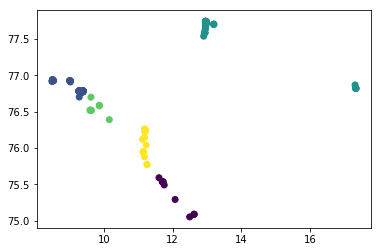

In [277]:
from scipy.cluster.vq import kmeans2, whiten
x, cluster_labels = kmeans2(np.radians(latlong).values.tolist(),max(cluster_labels), iter = 50)
plt.scatter(latlong['Latitude'], latlong['Longitude'], c=cluster_labels);
plt.show()

Generating bounding box (Convex Hull)

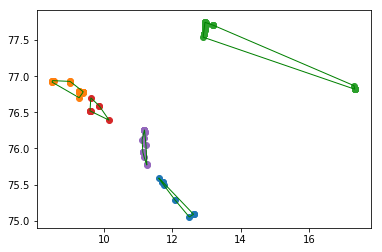

In [278]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
from scipy.spatial import ConvexHull
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)
    return poly


xcor=[]
ycor=[]
for i in range(max(cluster_labels)+1):
    xcor.append([])
    ycor.append([])
for i in range(max(cluster_labels)+1):
    for j in range(len(latlong)):
        if cluster_labels[j]==i:
            xcor[i].append(latlong.loc[j].values[0])
            ycor[i].append(latlong.loc[j].values[1])
            
for i in range(max(cluster_labels)+1):
    plt.scatter(xcor[i], ycor[i])

for i in range(max(cluster_labels)+1):
    if(len(xcor[i])>0):
        encircle(xcor[i], ycor[i], ec="green", fc="none")
plt.show()

In [279]:
import gmaps
def encircle(x,y):
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = p[hull.vertices,:]
    return poly
poly=[]
for i in range(max(cluster_labels)+1):
    if(len(xcor[i])>0):
        poly.append(encircle(xcor[i], ycor[i]).tolist())
drawing=[]
for i in range(len(poly)):
    drawing.append(gmaps.drawing_layer(features=[
         gmaps.Polygon(
             poly[i],
             fill_opacity=0,
             stroke_color='#000000',
             stroke_opacity=1
         )
    ]))

Generating layers for map

In [280]:
symbol_layers=[]

colors=['red','green',"blue","yellow","gray","black",'black','aqua', 'lime',"white"]
for i in range(max((cluster_labels))+1):
    cluster_locations=[]
    for j in range(len(cluster_labels)):
        if(cluster_labels[j]==i):
            cluster_locations.append(latlong.loc[j].values)
    symbol_layers.append(gmaps.symbol_layer(
            cluster_locations, fill_color=colors[i],scale=3,stroke_opacity=0))

Plotting on map


In [284]:
fig = gmaps.figure()
#fig.add_layer(gmaps.heatmap_layer(latlong, weights=np.ones(len(latlong), dtype = int) ))
for i in range(len(symbol_layers)):
    fig.add_layer(symbol_layers[i])

fig


Figure(layout=FigureLayout(height='420px'))

Plotting Heatmap

In [285]:
fig = gmaps.figure()
#fig.add_layer(gmaps.heatmap_layer(latlong, weights=np.ones(len(latlong), dtype = int) ))
fig.add_layer(gmaps.heatmap_layer(latlong, weights=None ))
for i in range(len(poly)):
    fig.add_layer(drawing[i])
fig


Figure(layout=FigureLayout(height='420px'))

# Finding the affected States & Districts and the level of impact

Working with shape files

In [6]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

district_file = shp.Reader("2011_Census_Data/2011_Dist.shp")
state_file = shp.Reader("Indian_States/Indian_States.shp")

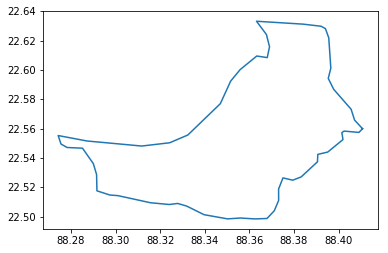

In [7]:
plt.figure()
for shape in district_file.shapeRecords():
    if(shape.record[0])=='Kolkata':
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y)
plt.show()

# Common for district and states

In [8]:
def color_map(weight):
    return {
        1: (61, 89, 65),
        2: (119, 136, 104),
        3: (181, 185, 145),
        4:  (246, 237, 189),
        5:   (237, 187, 138),
        6: (222, 138, 90),
        7:  (202, 86, 44),
        8: (255, 20, 44),
    }.get(weight, (0,0,0))
def state_map_weights(total_cases):
    if(total_cases==0):
        return 1
    if(total_cases<=10):
        return 2
    if(total_cases<=50):
        return 3
    if(total_cases<=100):
        return 4
    if(total_cases<=200):
        return 5
    if(total_cases<=400):
        return 6
    if(total_cases<=700):
        return 7
    return 8 
def district_map_weights(total_cases):
    if(total_cases<=10):
        return 1
    if(total_cases<=15):
        return 2
    if(total_cases<=20):
        return 3
    if(total_cases<=40):
        return 4
    if(total_cases<=50):
        return 5
    if(total_cases<=60):
        return 6
    if(total_cases<=70):
        return 7
    return 8 

In [9]:
#Function to return the number of total_cases,deceased and recovered patients of places (States/Districts) present mapping dictionary
#Parameters:
    #census_place: record of a row in the shapefile
    #place_mapping: Dictionary (either state_mapping or district_mapping
    #place_type: State/District
#Return Value: Total no. of cases,recovered and deceased.
def get_cases(census_place,place_mapping,type_place):
    recovered=0
    deceased=0
    key=[key  for (key, value) in place_mapping.items() if value == shape.record[0]]
    data_lowercase=data.groupby(["Detected "+type_place,"Current Status"]).size()
    data_lowercase.index=data_lowercase.index.set_levels(data_lowercase.index.levels[0].str.lower(), level=0)
    total_cases=sum(sum(data_lowercase[keys]) for keys in key)
    
    data_lowercase=data_death_and_recovered.groupby([type_place,"Patient Status"]).size()
    data_lowercase.index=data_lowercase.index.set_levels(data_lowercase.index.levels[0].str.lower(), level=0)
    
    recovered=sum(data_lowercase[keys]['Recovered'] for keys in key if keys in data_lowercase.index.levels[0] and 'Recovered' in data_lowercase[keys].keys())
    deceased=sum(data_lowercase[keys]['Deceased'] for keys in key if keys in data_lowercase.index.levels[0] and 'Deceased' in data_lowercase[keys].keys())
    return total_cases,recovered,deceased
#Function to return the number of deceased and recovered patients of places (States/Districts) present in covid19 dataset
#Parameters:
    #census_place: record of a row in the shapefile
    #place_type: State/District
#Return Value: Total no. of recovered and deceased.
def get_deceased_and_recovered(census_place,place_type):
    recovered=0
    deceased=0
    patient_stats=data_death_and_recovered.groupby([place_type,"Patient Status"]).size()
    if census_place in patient_stats.index.levels[0]:
        patient_stats=patient_stats[census_place]
        if 'Recovered' in patient_stats.keys():
            recovered=patient_stats['Recovered']
        if 'Deceased' in patient_stats.keys():
            deceased=patient_stats['Deceased']
    return recovered,deceased
#Function: Extracts all the polygons from a given set of coordinates
#Paramters:
    #shape: single row of shapefile
#Return Values: list of coordinates. Each element of latlong_island -> Polygon
def extract_boundaries(shape):
    latlong=[]
    latlong_islands=[]
    l=shape.points[:]
    l=np.array(l)
    for j in range(len(l)):
        latlong.append([l[j,1],l[j,0]]) #Extracting all coordinates from the 'shape' variable
        
    index=0 #Signifying the starting index value of a polygon
    for k in range(1,len(latlong),1):
        if(latlong[index]==latlong[k] and index!=k): #signifies a polygon is completed (inital point = final point)
            latlong_islands.append(latlong[index:k+1])
            index=k+1 #index updated at the beginning of each polygon
    if(index<len(latlong)): # For the last polygon
        latlong_islands.append(latlong[index:len(latlong)])
    return latlong_islands

#Function: Generates the layers where each layer contains a polygon
#Paramters:
    #latlong_islands: Sets of coordinates (each element of latlong_islands signifying one polygon)
    #weight: Set of weights determining intensity of cases'
#Return Values: Set of Layer to be added to gmaps.figure(). No. of layers-> No. of polygons

def add_layers(latlong_islands,total_cases,type_place):#U NEED TO CHANGE THIS i.e add color parameter --Srinjoy
    layer=[]
    if(type_place=='District'):
        weight=district_map_weights(total_cases)
    else:
        weight=state_map_weights(total_cases)
    for k in range(len(latlong_islands)-1): #Adding each polygon as a layer except last
        layer.append(gmaps.drawing_layer(features=[
        gmaps.Polygon(
             latlong_islands[k],
             fill_opacity=0.8,#U NEED TO CHANGE THIS --Srinjoy
             stroke_color='#000000',
             fill_color=color_map(weight), #U NEED TO CHANGE THIS --Srinjoy
             stroke_opacity=1, 
         )
        ]))
    return layer
#Function: Generates the layer containing polygon as well as symbol layer (required for infobox)
#Paramters:
    #latlong_islands: Sets of coordinates (each element of latlong_islands signifying one polygon)
    #weight: Set of weights determining intensity of cases'
    #center: Center of polygon for on_click button
    #place: District or State
    #total_cases: Total no. of cases in the place (state/district) [String]
    #type_place: Takes two values: 'State' or 'District'
#Return Values: Single Layer to be added to gmaps.figure()

def add_layers_with_symbol(latlong_islands,center,place,total_cases,recovered,deceased,type_place):#U NEED TO CHANGE THIS i.e add color parameter --Srinjoy
    layer=[] #Adding the single layer
    if(type_place=='District'):
        weight=district_map_weights(total_cases)
    else:
        weight   =state_map_weights(total_cases)
    layer.append(gmaps.drawing_layer(features=[
    gmaps.Symbol(center,fill_color="yellow",scale=2,fill_opacity=1,stroke_opacity=0.8, info_box_content=type_place+": "+place+"</br>"+"No. of Cases: "+str(total_cases)+"</br>"+"Recovered: "+str(recovered)+"</br>"+"Deceased: "+str(deceased)),
     gmaps.Polygon(
         latlong_islands,
         fill_opacity=0.8, #U NEED TO CHANGE THIS --Srinjoy
         stroke_color='#000000',
         fill_color=color_map(weight),#U NEED TO CHANGE THIS --Srinjoy
         stroke_opacity=1,
     )
    ]))
    return layer
def get_legend(interval):
    legend_template = '<span style="color: {color};opacity:{weight}; font-size: 2em; vertical-align: bottom;">&#9679;</span> {var}'
    legend_entries=[]
    for i in range(8):
        legend_entries.append(legend_template.format(color="rgb"+str(color_map(i+1)), weight=0.8,var=interval[i]))
    legend = widgets.HBox(
        [widgets.HTML(legend_entry) for legend_entry in legend_entries],
        layout=widgets.Layout(width='100%', justify_content='space-between')
    )
    return legend
    

# Districts

In [10]:
# Maps corona dataset districts to census data district
district_mapping = {
    # new covid : old 2011
    'Chengalpattu':'Kancheepuram',
    'Ranipet': 'Kancheepuram',
    'Pauri Garhwal': 'Garhwal' ,
    'Bhadradri Kothagudem': 'Khammam',
    'South Salmara Mancachar': 'Dhubri',
    'Nuh': 'Mewat',
    'Kalaburagi':'Gulbarga',
    'Saran': 'Saran (chhapra)',
    'Gir Somnath': 'Junagadh',
    'S.P.S. Nellore': 'Sri Potti Sriramulu Nellore',
    'S.A.S. Nagar': 'Sahibzada Ajit Singh Nagar',
    'Virudhunagar': 'Virudunagar',
    'Medchal Malkajgiri': 'Malkangiri',
    'Bagalkote':'Bagalkot',
    'Belagavi':'Belgaum',
    'Ballari': 'Bellary',
    'Tirupathur': 'Tiruppur',
    'Ranga Reddy':'Rangareddy',
    'Jhunjhunu':'Jhunjhunun',
    'Tumakuru': 'Tumkur',
    'Morigaon':'Marigaon',
    'Hooghly':'Hugli',
    'Howrah':'Haora',
    'Gurugram':'Gurgaon',
    'Haridwar':'Hardwar',
    'Bengaluru': 'Bangalore',
    'Bengaluru Rural':'Bangalore',
    'Nagapattinam':'Nagappattinam',
    'Medinipur East':'Purba Medinipur',
    'Medinipur West':'Paschim Medinipur',
    'Champaran West':'Paschim Champaran',
    'Kalimpong':'Darjiling',
    'Mysuru':'Mysore',
    'Leh':'Leh (ladakh)',
    "Y.S.R.":'Y.s.r.',
    'Chota Udaipur':'Vadodara',
    'Hatras':'Aligarh',
    'Hapur':'Ghaziabad',
    'Sangareddy':'Medak',
    'Warangal Urban':'Warangal',
    'Khargone':'West Nimar',
    'Nirmal':'Adilabad',
    'Morbi':'Rajkot',
    'Shamli':'Muzaffarnagar',
    'Kallakurichi':'Viluppuram',
    'Pathankot':'Gurdaspur',
    'Peddapalli':'Karimnagar',
    'Vikarabad':'Rangareddy',
    'Gomati':'South Tripura',
    'Prayagraj':'Allahabad',
    'Charki Dadri':'Bhiwani',
    'Mahrajganj':'Maharajganj',
    'Jagitial':'Karimnagar',
    'Kashmir':'Srinagar',
    'Mahabubnagar':'Mahbubnagar',
    'Jogulamba Gadwal':'Mahbubnagar',
    'Suryapet':'Nalgonda',
    'Khandwa':'East Nimar',
    'Dahod':'Dohad',
    'Tenkasi':'Tirunelveli',
    'Thirupathur':'Vellore',
    'Sri Muktsar Sahib':'Muktsar',
    'Amroha':'Jyotiba Phule Nagar',
    '':''
   
}


district_mapping={k.lower(): v for k, v in district_mapping.items()}

To check if update is required to the dictionary (optional)

In [20]:
districts=data.groupby("Detected District").size().keys()
for i in range(len(districts)):
    flag=0
    for shape in district_file.shapeRecords():
        if("&" in shape.record[0]): # for e.g J & K converted to J and K
            shape.record[0]=shape.record[0].replace("&","and")
        if(shape.record[0] in ['East','West','North','South','North West','North East','South East','South West']):
            shape.record[0]=shape.record[0]+" "+shape.record[1].split(" ")[-1]
        if(shape.record[0].lower()==districts[i].lower() or (districts[i].lower() in district_mapping.keys() and shape.record[0].lower()==district_mapping[districts[i].lower()].lower())):
            flag=1
            break
    #List of districts not found in the updated covid19 dataset
    if(flag==0):
        print(districts[i])
        


Amroha
Evacuees
Gujarat*
Italians*
Other Region*
Other States


Generating layers for all districts

In [11]:
districts_affected = data.groupby(["Detected District"]).size()
districts=np.array(districts_affected.keys())
district_layer=[]
for shape in district_file.shapeRecords(): #iterating through the census shapefile
    #print(shape.record[0])
    total_cases=0
    
    if("&" in shape.record[0]): # for e.g J & K converted to J and K
        shape.record[0]=shape.record[0].replace("&","and")
    if(shape.record[0] in ['East','West','North','South','North West','North East','South East','South West','Central']):
        shape.record[0]=shape.record[0]+" "+shape.record[1].split(" ")[-1]
    
    # If district name exists in district_mappping dictionary we assign no. of total_cases to 'total_cases'           
    if shape.record[0] in district_mapping.values():
        total_cases,recovered,deceased=get_cases(shape.record[0],district_mapping,"District")

        
    # if district name exists in covid19 dataset we assign no. of total_cases to 'total_cases'
    elif shape.record[0] in districts:
        total_cases=data.groupby("Detected District").size()[shape.record[0]]
        recovered,deceased=get_deceased_and_recovered(shape.record[0],"District")
        
    if(total_cases==0):
        continue
        
    latlong_islands=extract_boundaries(shape.shape)
    district_layer.extend(add_layers(latlong_islands,total_cases,"District")) #U may add color parameter here --Srinjoy
        
     # Appending the final Layer and adding a symbol_on_click service with it
    center=[(min(np.array(shape.shape.points[:])[:,1])+max(np.array(shape.shape.points[:])[:,1]))/2,(min(np.array(shape.shape.points[:])[:,0])+max(np.array(shape.shape.points[:])[:,0]))/2]
    district_layer.extend(add_layers_with_symbol(latlong_islands[-1],center,shape.record[0],total_cases,recovered,deceased,"District")) #U may add color parameter here --Srinjoy
            

        
    

Plotting on map

In [12]:
fig = gmaps.figure(center=(23.2599, 77.4126), zoom_level=4,display_toolbar=False,)
for i in range(len(district_layer)):
    fig.add_layer(district_layer[i])
interval=["Less than 10","Less than 15","Less than 20","Less than 40","Less than 50","Less than 60","Less than 70","Greater than 700"]
legend=get_legend(interval)
widgets.VBox([fig, legend])


# States

In [13]:
# Maps corona dataset states to census data states
state_mapping = {
    # new covid : old 2011
    'Jammu and Kashmir' :'Jammu & Kashmir',
    'Ladakh' :'Jammu & Kashmir',
    'Delhi': 'NCT of Delhi',
    'Arunachal Pradesh' :'Arunanchal Pradesh' ,
    'Andaman and Nicobar Islands': 'Andaman & Nicobar Island',
    'Dadra and Nagar Haveli':'Dadara & Nagar Havelli',
    '': '',
   
}
state_mapping={k.lower(): v for k, v in state_mapping.items()}

To check if update is required to the dictionary (optional)

In [14]:
states_affected = data.groupby(["Detected State"]).size()
states=np.array(states_affected.keys())
for i in range(len(states)):
    flag=0
    for shape in state_file.shapeRecords():
        if(shape.record[0].lower()==states[i].lower() or (states[i].lower() in state_mapping.keys() and shape.record[0].lower()==state_mapping[states[i].lower()].lower())):
            flag=1
            break
    #List of states not found in the updated covid19 dataset
    if(flag==0):
        print(states[i])

Generating layers for all states

In [15]:
states_affected = data.groupby(["Detected State"]).size()
states=np.array(states_affected.keys())
states_layer=[]
for shape in state_file.shapeRecords():
    #print(shape.record[0])
    total_cases=0
    
    # If state name exists in state_mappping dictionary we assign no. of total_cases to 'total_cases'            
    if shape.record[0] in state_mapping.values():
        total_cases,recovered,deceased=get_cases(shape.record[0],state_mapping,"State")
        
    # if state name exists in covid19 dataset we assign no. of total_cases to 'total_cases'   
    elif shape.record[0] in states:
        total_cases=data.groupby("Detected State").size()[shape.record[0]]
        recovered,deceased=get_deceased_and_recovered(shape.record[0],"State")
    
    latlong_islands=extract_boundaries(shape.shape)
    states_layer.extend(add_layers(latlong_islands,total_cases,"State")) #U may add color parameter here --Srinjoy

     # Appending the final Layer and adding a symbol_on_click service with it
    center=[(min(np.array(shape.shape.points[:])[:,1])+max(np.array(shape.shape.points[:])[:,1]))/2,(min(np.array(shape.shape.points[:])[:,0])+max(np.array(shape.shape.points[:])[:,0]))/2]
    if(shape.record[0]=='Puducherry'): #Includes certain colonies in Maharashtra as well which creates problems while selecting infobox position
        center=[(min(np.array(latlong_islands[4])[:,0])+max(np.array(latlong_islands[4])[:,0]))/2,(min(np.array(latlong_islands[4])[:,1])+max(np.array(latlong_islands[4])[:,1]))/2]
    
    states_layer.extend(add_layers_with_symbol(latlong_islands[-1],center,shape.record[0],total_cases,recovered,deceased,"State")) #U may add color parameter here --Srinjoy
            


Plotting on map

In [16]:
fig = gmaps.figure(center=(23.2599, 77.4126), zoom_level=4,display_toolbar=False)
for i in range(len(states_layer)):
    fig.add_layer(states_layer[i])
interval=["No cases","Less than 10","Less than 50","Less than 100","Less than 200","Less than 400","Less than 700","Greater than 700"]
legend=get_legend(interval)
widgets.VBox([fig, legend])